In [1]:
import pandas as pd 
import os
from IPython.display import display,Audio
import cv2
import matplotlib.pyplot as plt
import librosa
from datasets import load_dataset, load_metric
from scipy.io.wavfile import write
import random
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn import preprocessing

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

In [3]:
dataset = torchaudio.datasets.SPEECHCOMMANDS("./", url="speech_commands_v0.02", download=True)
#test_dataset = torchaudio.datasets.SPEECHCOMMANDS("./", url="test-clean", download=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [4]:
!rm ./speech_commands_v0.02.tar.gz

In [5]:
#superb_dataset = load_dataset("superb","asr", split="train")

In [6]:
os.mkdir("./SpeechCommands/speech_commands_v0.02/noise")

In [7]:
#shutil.rmtree('./SpeechCommands/speech_commands_v0.02/noise')

In [8]:
def superb_noise(superb_dataset):
    for index in range(500):
        array_sample = superb_dataset[index*14]['audio']['array']
        array_range = len(array_sample)-16001
        random_point = random.randint(0,array_range)
        new_array_sample = array_sample[random_point:random_point+16000]
        write('./SpeechCommands/speech_commands_v0.02/noise/'+str(index)+'.wav', 16000, new_array_sample)
    
def background_noise():
    noise_path = '/kaggle/working/SpeechCommands/speech_commands_v0.02/_background_noise_'
    for noise_file_name in os.listdir(noise_path):
        if noise_file_name != 'README.md':
            noise = torchaudio.load(os.path.join(noise_path,noise_file_name))
            index = 0
            noise = noise[0][0].numpy()
            print(noise)
            while True:
                if index*320000+16000 < len(noise):
                    part_noise = noise[index*320000:index*320000+16000]
                    index+=1
                    write(os.path.join(
                            '/kaggle/working/SpeechCommands/speech_commands_v0.02/',
                            'noise',
                            noise_file_name+'_'+str(index)+'.wav'),
                          16000,
                          part_noise,
                    )
                else:
                    break
        print(noise_file_name)

def commands_noise():
    commands_list = ['go','stop','up','down','backward','left','right','noise']
    commands_set = set(commands_list)
    commands_set.add('validation_list.txt')
    commands_set.add('LICENSE')
    commands_set.add('.DS_Store')
    commands_set.add('_background_noise_')
    commands_set.add('testing_list.txt')
    commands_set.add('README.md')
    index=0
    other_commands_folder_path = '/kaggle/working/SpeechCommands/speech_commands_v0.02'
    for command_folder in os.listdir(other_commands_folder_path):
        if command_folder not in commands_set:
            index+=1
            command_folder_path = os.path.join(other_commands_folder_path,command_folder)
            com_list = os.listdir(command_folder_path)
            #print(len(com_list))
            step_iter = len(com_list)//20
            for command_index in range(20):
                command_wav_name = com_list[command_index*step_iter]
                src = os.path.join(command_folder_path,command_wav_name)
                dst = os.path.join(other_commands_folder_path,'noise',command_wav_name)
                shutil.copy(src,dst)

In [9]:
#superb_noise(superb_dataset)
background_noise()
commands_noise()

README.md
[0.6610718 0.3168335 0.4208374 ... 0.4595337 0.2564087 0.5492554]
pink_noise.wav
[ 0.          0.          0.         ... -0.02764893 -0.01760864
  0.00912476]
exercise_bike.wav
[ 0.          0.          0.         ... -0.02288818 -0.06027222
  0.006073  ]
running_tap.wav
[ 0.          0.          0.         ... -0.00592041 -0.00405884
 -0.00253296]
doing_the_dishes.wav
[-0.05389404 -0.49334717 -0.5333557  ... -0.23934937  0.36676025
 -0.15600586]
white_noise.wav
[ 0.          0.          0.         ...  0.00289917  0.00338745
 -0.00033569]
dude_miaowing.wav


In [10]:
#del superb_dataset

In [11]:
'''
commands = ['stop','down', 'five', 'off', 'house', 'marvin', 'eight', 'sheila', 'right', 'yes',
            'zero', 'one', 'left', 'go', 'seven', 'bird', 'bed', 'tree', 'cat', 'six', 'no',
            'three', 'four', 'backward', 'wow', 'dog', 'nine', 'two', 'forward']
'''
        
characters_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
            'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
            's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

commands_list = ['go','stop','up','down','backward','left','right','noise']


In [12]:
class TextProcessed:
    def __init__(self,characters = None,commands = None):
        if characters != None:
            #For transcription recognize
            self.characters = characters
            self.characters_map = dict()
            self.index_characters_map = dict()
            for i, character in enumerate(self.characters):
                self.characters_map[character] = i
                self.index_characters_map[i] = character
        if commands != None:
            #for classification
            self.commands = commands
            self.commands_dict = dict()
            self.index_commands_dict = dict()
            for i, command in enumerate(self.commands):
                self.commands_dict[command] = i
                self.index_commands_dict[i] = command
                
    def text2int(self, text):
        int_list = list()
        for ch in text:
            int_list.append(self.characters_map[ch])
        return int_list
    
    def int2text(self, int_list):
        ch_list = list()
        for int_ch in int_list:
            ch_list.append(self.index_characters_map[int_ch])
        return ''.join(ch_list)


In [13]:
tp = TextProcessed(characters = characters_list)
print(tp.text2int('stop'))
print(tp.int2text([18, 19, 14, 15]))
print('\n','characters: ',tp.characters_map)
tp = TextProcessed(commands = commands_list)
print('\n','commands: ',tp.commands_dict)

[18, 19, 14, 15]
stop

 characters:  {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}

 commands:  {'go': 0, 'stop': 1, 'up': 2, 'down': 3, 'backward': 4, 'left': 5, 'right': 6, 'noise': 7}


In [14]:
dataset_directory = './SpeechCommands/speech_commands_v0.02'

validation_list_txt = open(os.path.join(dataset_directory,'validation_list.txt'), "r")
validation_list_str = validation_list_txt.read()
validation_list = validation_list_str.split('\n')

testing_list_txt = open(os.path.join(dataset_directory,'testing_list.txt'), "r")
testing_list_str = testing_list_txt.read()
testing_list = testing_list_str.split('\n')

commands_df = pd.DataFrame(columns = ['command','filename','train_val_test','path'])

for command in commands_list:
    print(command,'command','is processed...')
    listdir_command = os.listdir(os.path.join(dataset_directory,command))
    for pattern in listdir_command:
        path = os.path.join(command,pattern)
        if path in validation_list:
            train_val_test = 'val'
        elif path in testing_list:
            train_val_test = 'test'
        else:
            train_val_test = 'train'
        #print([commands_dict[command],command,path,train_val])
        commands_df.loc[len(commands_df)] = [command,
                                             pattern.split('.')[0],
                                             train_val_test,
                                             path]
commands_df.to_csv('./commands_annotations.csv',index=False)
commands_df

go command is processed...
stop command is processed...
up command is processed...
down command is processed...
backward command is processed...
left command is processed...
right command is processed...
noise command is processed...


,command,filename,train_val_test,path
0,go,a7dd45cf_nohash_0,val,go/a7dd45cf_nohash_0.wav
1,go,9448c397_nohash_0,train,go/9448c397_nohash_0.wav
2,go,4954abe8_nohash_0,train,go/4954abe8_nohash_0.wav
3,go,c38720cb_nohash_2,train,go/c38720cb_nohash_2.wav
4,go,ef3367d9_nohash_0,train,go/ef3367d9_nohash_0.wav
...,...,...,...,...
25130,noise,48463cbc_nohash_1,train,noise/48463cbc_nohash_1.wav
25131,noise,1093c8e7_nohash_1,train,noise/1093c8e7_nohash_1.wav
25132,noise,333784b7_nohash_3,train,noise/333784b7_nohash_3.wav
25133,noise,712e4d58_nohash_0,train,noise/712e4d58_nohash_0.wav


In [15]:
class CommandDataset(Dataset):
    def __init__(self,csv_file, root_dir,train_val_test,transform=None,characters_list=None, commands_list = None):
        self.df = pd.read_csv(csv_file)
        self.commands_dframe = self.df.loc[self.df['train_val_test'] == train_val_test]
        self.root_dir = root_dir
        self.transform = transform
        self.train_val_test = train_val_test
        if commands_list != None:
            self.commands_tp = TextProcessed(commands = commands_list)
        display(self.commands_dframe)
    def __len__(self):
        return len(self.commands_dframe)
    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(os.path.join(self.root_dir,
                                                             self.commands_dframe.iloc[idx]['path']),
                                                normalize=True
                                               )
        if self.commands_tp:
            label = self.commands_dframe.iloc[idx]['command']
            label = self.commands_tp.commands_dict[label]
        return waveform,sample_rate,label
        '''
        if train_val_test == 'train':
            transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
            #frequency_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=2)
            #time_masking = torchaudio.transforms.TimeMasking(time_mask_param=5)
            mel_specgram = transform(waveform)
            if self.commands_tp:
                label = self.commands_dframe.iloc[idx]['command']
                label = self.commands_tp.commands_dict[label]
            #fr_mask = frequency_mask(mel_specgram)
            #time_mask =time_masking(fr_mask)
            return mel_specgram, waveform, label # waveform, sample_rate,fr_mask,time_mask
        '''
            
        
    

In [16]:
def melTransform(waveform,sample_rate):
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
    return transform(waveform)

In [17]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [18]:
train_dataset = CommandDataset('./commands_annotations.csv',dataset_directory,'train',commands_list=commands_list)
val_dataset = CommandDataset('./commands_annotations.csv',dataset_directory,'val',commands_list=commands_list)
test_dataset = CommandDataset('./commands_annotations.csv',dataset_directory,'test',commands_list=commands_list)

,command,filename,train_val_test,path
1,go,9448c397_nohash_0,train,go/9448c397_nohash_0.wav
2,go,4954abe8_nohash_0,train,go/4954abe8_nohash_0.wav
3,go,c38720cb_nohash_2,train,go/c38720cb_nohash_2.wav
4,go,ef3367d9_nohash_0,train,go/ef3367d9_nohash_0.wav
5,go,eaa83485_nohash_1,train,go/eaa83485_nohash_1.wav
...,...,...,...,...
25130,noise,48463cbc_nohash_1,train,noise/48463cbc_nohash_1.wav
25131,noise,1093c8e7_nohash_1,train,noise/1093c8e7_nohash_1.wav
25132,noise,333784b7_nohash_3,train,noise/333784b7_nohash_3.wav
25133,noise,712e4d58_nohash_0,train,noise/712e4d58_nohash_0.wav


,command,filename,train_val_test,path
0,go,a7dd45cf_nohash_0,val,go/a7dd45cf_nohash_0.wav
46,go,3a929277_nohash_0,val,go/3a929277_nohash_0.wav
53,go,525eaa62_nohash_0,val,go/525eaa62_nohash_0.wav
57,go,73f20b00_nohash_3,val,go/73f20b00_nohash_3.wav
82,go,fa52ddf6_nohash_0,val,go/fa52ddf6_nohash_0.wav
...,...,...,...,...
24608,right,f6a380e7_nohash_0,val,right/f6a380e7_nohash_0.wav
24609,right,0d82fd99_nohash_3,val,right/0d82fd99_nohash_3.wav
24616,right,856eb138_nohash_2,val,right/856eb138_nohash_2.wav
24620,right,9d32f10a_nohash_1,val,right/9d32f10a_nohash_1.wav


,command,filename,train_val_test,path
7,go,beb458a4_nohash_4,test,go/beb458a4_nohash_4.wav
38,go,a7216980_nohash_3,test,go/a7216980_nohash_3.wav
39,go,e41a903b_nohash_2,test,go/e41a903b_nohash_2.wav
42,go,4845bb10_nohash_0,test,go/4845bb10_nohash_0.wav
48,go,0c40e715_nohash_0,test,go/0c40e715_nohash_0.wav
...,...,...,...,...
24597,right,2d82a556_nohash_1,test,right/2d82a556_nohash_1.wav
24603,right,9a69672b_nohash_0,test,right/9a69672b_nohash_0.wav
24615,right,3efef882_nohash_1,test,right/3efef882_nohash_1.wav
24625,right,5c8af87a_nohash_0,test,right/5c8af87a_nohash_0.wav


In [19]:
index = 9000

waveform,sample_rate,label = train_dataset[index]

print(label,' -> ',train_dataset.df.iloc[index]['command'])

2  ->  up


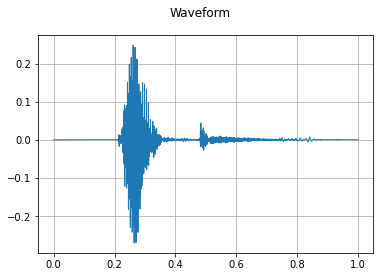

torch.Size([1, 16000])

In [20]:
plot_waveform(waveform,sample_rate)
waveform.shape

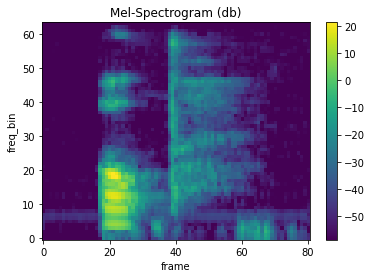

torch.Size([1, 64, 81])

In [21]:
plot_spectrogram(melTransform(waveform,sample_rate)[0],title='Mel-Spectrogram (db)')
melTransform(waveform,sample_rate).shape

In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch
    #return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label in batch:
        #print(melTransform(waveform,sample_rate).shape)
        tensors += [melTransform(waveform,sample_rate)[0]]
        targets += [label]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    tensors = tensors.permute([0,2,1])
    new_dim_tensor = []
    for tensor in tensors:
        #print(torch.unsqueeze(tensor, dim=0).shape)
    #    print(tensor.permute([1,81,64]).shape)
        new_dim_tensor += [torch.unsqueeze(tensor, dim=0)]
    #print(torch.Tensor(new_dim_tensor).shape)
    new_tensor = torch.stack(new_dim_tensor)
    targets = torch.Tensor(targets)

    return new_tensor, targets

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    #num_workers=0,
    #pin_memory=False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    #num_workers=0,
    #pin_memory=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    #num_workers=0,
    #pin_memory=False,
)

In [24]:
class NN2DMEL(nn.Module):
    def __init__(self, num_class):
        super(NN2DMEL,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1)
        self.dropout1 = nn.Dropout(0.3) 
    
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
        self.dropout2 = nn.Dropout(0.3)
        
        #self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        #self.dropout3 = nn.Dropout(0.3)
        
        #self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        #self.dropout4 = nn.Dropout(0.3)
        
        #self.fc0 = nn.Linear(1664, 256)
        
        self.fc1 = nn.Linear(768, 2048)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(2048,128)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_class)
        '''
        
        self.fc1 = nn.Linear(64, 1024)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024,128)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_class)
        '''
        '''
        self.fc1 = nn.Linear(64, 64)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64,32)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, num_class)
        '''
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)
        
        #x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=3)
        #x = self.dropout3(x)
        #print(x.shape)
        #x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=3)
        #x = self.dropout4(x)
        #print(x.shape)
        #print(x.shape)
        #print(x.shape)
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2]*x.shape[3])))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        
        #print(x.shape)
        return x 

In [25]:
net = NN2DMEL(num_class=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

net = net.to(device)

num_epochs=300

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=num_epochs,
                                              anneal_strategy='linear')


cuda


In [26]:
from tqdm import tqdm
best_acc = 0
for epoch in range(0, num_epochs):
    print("Training")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    
    iterator = tqdm(train_loader)
    
    for tuple_ in iterator:
        
        inputs,targets = tuple_[0].to(device),tuple_[1].to(device) #tuple_[0].to(device), tuple_[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        labels = torch.tensor([int(x) for x in targets]).to(device)
        
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
        
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1,
                                                                  train_loss/len(train_loader),
                                                                  total_correct*100/total))
    print("\nvalidation")
    net.eval()
    test_loss,total_test,total_correct_test = 0,0,0
    
    iterator = tqdm(test_loader)
    for tuple_test in iterator:
        
        inputs,targets = tuple_test[0].to(device),tuple_test[1].to(device)
        labels = torch.tensor([int(x) for x in targets]).to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += targets.size(0)
        total_correct_test += (predicted == targets).sum().item()
    acc = 100. * total_correct_test / total_test
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch+1, test_loss/len(test_loader), acc))
    
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    save_point = './checkpoint/'
    if not os.path.isdir(save_point):
        os.mkdir(save_point)
    torch.save(net.state_dict(), save_point+f'epoch_{epoch}'+'.pth')
    
    if acc >= best_acc:
        print('===BEST ACC===')
        '''
        if isinstance(net, torch.nn.DataParallel):
            print("multiple GPU")
            print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                'model':net.module.state_dict(),
                'model1': net.state_dict(),
                'model2': net,
                'acc':acc,
                'epoch':epoch,
            }
        
        else:
            print("not multiple GPU")
            state = {
                    'model':net,
                    'acc':acc,
                    'epoch':epoch,
                    }  
        '''
        '''
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(net.state_dict(), save_point+f'epoch_{epoch}'+'.pth')
        '''
        best_acc = acc
    
#train(net,train_loader,optimizer,scheduler,criterion,epoch,device)
#best_acc = test(net,val_loader,optimizer,criterion,epoch,device)

Training


100%|██████████| 1263/1263 [00:35<00:00, 35.28it/s]


Epoch: [1]  loss: [2.37] Accuracy [17.99] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.73it/s]



Validation Epoch #1			Loss: 2.0133 Acc@1: 19.76%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:29<00:00, 43.42it/s]


Epoch: [2]  loss: [2.03] Accuracy [20.39] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.66it/s]



Validation Epoch #2			Loss: 1.9816 Acc@1: 25.07%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.65it/s]


Epoch: [3]  loss: [2.00] Accuracy [23.00] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.46it/s]



Validation Epoch #3			Loss: 1.9077 Acc@1: 28.85%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:29<00:00, 43.08it/s]


Epoch: [4]  loss: [1.97] Accuracy [25.96] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.06it/s]



Validation Epoch #4			Loss: 1.8508 Acc@1: 31.79%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:29<00:00, 43.07it/s]


Epoch: [5]  loss: [1.92] Accuracy [28.34] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.29it/s]



Validation Epoch #5			Loss: 1.7950 Acc@1: 35.04%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.78it/s]


Epoch: [6]  loss: [1.86] Accuracy [29.65] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.17it/s]



Validation Epoch #6			Loss: 1.6926 Acc@1: 38.75%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:29<00:00, 43.53it/s]


Epoch: [7]  loss: [1.81] Accuracy [32.16] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.52it/s]



Validation Epoch #7			Loss: 1.6302 Acc@1: 37.45%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.16it/s]


Epoch: [8]  loss: [1.73] Accuracy [34.75] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.69it/s]



Validation Epoch #8			Loss: 1.5105 Acc@1: 43.33%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.05it/s]


Epoch: [9]  loss: [1.63] Accuracy [39.15] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.96it/s]



Validation Epoch #9			Loss: 1.3766 Acc@1: 51.85%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.14it/s]


Epoch: [10]  loss: [1.54] Accuracy [43.78] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.43it/s]



Validation Epoch #10			Loss: 1.2515 Acc@1: 56.29%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.63it/s]


Epoch: [11]  loss: [1.43] Accuracy [48.58] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.90it/s]



Validation Epoch #11			Loss: 1.1357 Acc@1: 62.48%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.47it/s]


Epoch: [12]  loss: [1.33] Accuracy [53.04] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.17it/s]



Validation Epoch #12			Loss: 1.0393 Acc@1: 65.99%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.05it/s]


Epoch: [13]  loss: [1.24] Accuracy [56.47] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.92it/s]



Validation Epoch #13			Loss: 0.9651 Acc@1: 68.17%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.03it/s]


Epoch: [14]  loss: [1.17] Accuracy [59.29] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.75it/s]



Validation Epoch #14			Loss: 0.8937 Acc@1: 71.38%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.45it/s]


Epoch: [15]  loss: [1.11] Accuracy [61.85] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.89it/s]



Validation Epoch #15			Loss: 0.8508 Acc@1: 72.91%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.60it/s]


Epoch: [16]  loss: [1.05] Accuracy [64.35] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.47it/s]



Validation Epoch #16			Loss: 0.7915 Acc@1: 75.32%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.20it/s]


Epoch: [17]  loss: [0.99] Accuracy [66.31] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.34it/s]



Validation Epoch #17			Loss: 0.7551 Acc@1: 77.19%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.33it/s]


Epoch: [18]  loss: [0.96] Accuracy [67.79] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.48it/s]



Validation Epoch #18			Loss: 0.7137 Acc@1: 77.49%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 45.00it/s]


Epoch: [19]  loss: [0.93] Accuracy [69.16] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.55it/s]



Validation Epoch #19			Loss: 0.6791 Acc@1: 78.03%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.59it/s]


Epoch: [20]  loss: [0.89] Accuracy [70.40] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.11it/s]



Validation Epoch #20			Loss: 0.6437 Acc@1: 80.28%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.84it/s]


Epoch: [21]  loss: [0.87] Accuracy [70.95] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.88it/s]



Validation Epoch #21			Loss: 0.6252 Acc@1: 80.47%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.26it/s]


Epoch: [22]  loss: [0.83] Accuracy [72.60] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.14it/s]



Validation Epoch #22			Loss: 0.6179 Acc@1: 81.47%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.28it/s]


Epoch: [23]  loss: [0.81] Accuracy [73.44] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.21it/s]



Validation Epoch #23			Loss: 0.5847 Acc@1: 82.84%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.71it/s]


Epoch: [24]  loss: [0.78] Accuracy [74.49] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.32it/s]



Validation Epoch #24			Loss: 0.5797 Acc@1: 82.88%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.12it/s]


Epoch: [25]  loss: [0.76] Accuracy [74.47] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.08it/s]



Validation Epoch #25			Loss: 0.5731 Acc@1: 82.58%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.73it/s]


Epoch: [26]  loss: [0.74] Accuracy [75.53] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.71it/s]



Validation Epoch #26			Loss: 0.5429 Acc@1: 83.11%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.17it/s]


Epoch: [27]  loss: [0.71] Accuracy [76.43] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.91it/s]



Validation Epoch #27			Loss: 0.5187 Acc@1: 84.29%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.35it/s]


Epoch: [28]  loss: [0.70] Accuracy [76.63] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.17it/s]



Validation Epoch #28			Loss: 0.5106 Acc@1: 84.68%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.40it/s]


Epoch: [29]  loss: [0.69] Accuracy [77.23] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.49it/s]



Validation Epoch #29			Loss: 0.5064 Acc@1: 84.75%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.70it/s]


Epoch: [30]  loss: [0.67] Accuracy [77.74] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.95it/s]



Validation Epoch #30			Loss: 0.4721 Acc@1: 84.37%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.92it/s]


Epoch: [31]  loss: [0.66] Accuracy [78.32] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.21it/s]



Validation Epoch #31			Loss: 0.4767 Acc@1: 84.98%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.37it/s]


Epoch: [32]  loss: [0.64] Accuracy [79.05] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.54it/s]



Validation Epoch #32			Loss: 0.4743 Acc@1: 85.21%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.16it/s]


Epoch: [33]  loss: [0.62] Accuracy [79.30] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.76it/s]



Validation Epoch #33			Loss: 0.4632 Acc@1: 85.67%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.40it/s]


Epoch: [34]  loss: [0.61] Accuracy [80.07] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.15it/s]



Validation Epoch #34			Loss: 0.4580 Acc@1: 86.09%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.15it/s]


Epoch: [35]  loss: [0.59] Accuracy [80.46] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.87it/s]



Validation Epoch #35			Loss: 0.4399 Acc@1: 86.47%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.12it/s]


Epoch: [36]  loss: [0.59] Accuracy [80.58] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.35it/s]



Validation Epoch #36			Loss: 0.4425 Acc@1: 86.59%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.11it/s]


Epoch: [37]  loss: [0.59] Accuracy [81.04] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.89it/s]



Validation Epoch #37			Loss: 0.4577 Acc@1: 86.32%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.30it/s]


Epoch: [38]  loss: [0.57] Accuracy [81.15] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.94it/s]



Validation Epoch #38			Loss: 0.4450 Acc@1: 86.01%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.94it/s]


Epoch: [39]  loss: [0.56] Accuracy [81.59] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.43it/s]



Validation Epoch #39			Loss: 0.4472 Acc@1: 86.82%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.41it/s]


Epoch: [40]  loss: [0.55] Accuracy [81.77] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.36it/s]



Validation Epoch #40			Loss: 0.4403 Acc@1: 86.17%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.82it/s]


Epoch: [41]  loss: [0.55] Accuracy [81.72] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.15it/s]



Validation Epoch #41			Loss: 0.4427 Acc@1: 86.51%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.89it/s]


Epoch: [42]  loss: [0.55] Accuracy [82.18] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.91it/s]



Validation Epoch #42			Loss: 0.4271 Acc@1: 87.24%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.20it/s]


Epoch: [43]  loss: [0.53] Accuracy [82.51] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.89it/s]



Validation Epoch #43			Loss: 0.4005 Acc@1: 87.50%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.55it/s]


Epoch: [44]  loss: [0.51] Accuracy [83.08] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.04it/s]



Validation Epoch #44			Loss: 0.4133 Acc@1: 87.54%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.30it/s]


Epoch: [45]  loss: [0.52] Accuracy [82.82] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.85it/s]



Validation Epoch #45			Loss: 0.4060 Acc@1: 88.00%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.44it/s]


Epoch: [46]  loss: [0.51] Accuracy [83.12] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.87it/s]



Validation Epoch #46			Loss: 0.3991 Acc@1: 87.54%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.49it/s]


Epoch: [47]  loss: [0.51] Accuracy [83.14] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.94it/s]



Validation Epoch #47			Loss: 0.4122 Acc@1: 87.77%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.58it/s]


Epoch: [48]  loss: [0.51] Accuracy [83.26] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.14it/s]



Validation Epoch #48			Loss: 0.4248 Acc@1: 86.66%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.16it/s]


Epoch: [49]  loss: [0.50] Accuracy [83.59] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.83it/s]



Validation Epoch #49			Loss: 0.4324 Acc@1: 86.97%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.98it/s]


Epoch: [50]  loss: [0.49] Accuracy [83.95] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.25it/s]



Validation Epoch #50			Loss: 0.4131 Acc@1: 87.35%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.34it/s]


Epoch: [51]  loss: [0.49] Accuracy [83.76] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.04it/s]



Validation Epoch #51			Loss: 0.4065 Acc@1: 88.19%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.65it/s]


Epoch: [52]  loss: [0.49] Accuracy [83.90] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.39it/s]



Validation Epoch #52			Loss: 0.3861 Acc@1: 87.85%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.15it/s]


Epoch: [53]  loss: [0.48] Accuracy [84.09] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.20it/s]



Validation Epoch #53			Loss: 0.3743 Acc@1: 88.73%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.39it/s]


Epoch: [54]  loss: [0.48] Accuracy [84.16] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.52it/s]



Validation Epoch #54			Loss: 0.3825 Acc@1: 88.12%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.92it/s]


Epoch: [55]  loss: [0.47] Accuracy [84.35] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.03it/s]



Validation Epoch #55			Loss: 0.3980 Acc@1: 88.27%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.96it/s]


Epoch: [56]  loss: [0.47] Accuracy [84.87] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.95it/s]



Validation Epoch #56			Loss: 0.3897 Acc@1: 88.04%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.29it/s]


Epoch: [57]  loss: [0.47] Accuracy [84.58] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.15it/s]



Validation Epoch #57			Loss: 0.3943 Acc@1: 87.28%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.75it/s]


Epoch: [58]  loss: [0.47] Accuracy [84.89] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.68it/s]



Validation Epoch #58			Loss: 0.3673 Acc@1: 88.38%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.98it/s]


Epoch: [59]  loss: [0.47] Accuracy [84.80] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.30it/s]



Validation Epoch #59			Loss: 0.3826 Acc@1: 88.08%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.30it/s]


Epoch: [60]  loss: [0.45] Accuracy [85.36] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.63it/s]



Validation Epoch #60			Loss: 0.3775 Acc@1: 87.89%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.71it/s]


Epoch: [61]  loss: [0.46] Accuracy [85.08] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.55it/s]



Validation Epoch #61			Loss: 0.3738 Acc@1: 87.66%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.66it/s]


Epoch: [62]  loss: [0.48] Accuracy [84.58] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.11it/s]



Validation Epoch #62			Loss: 0.3545 Acc@1: 88.88%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.31it/s]


Epoch: [63]  loss: [0.45] Accuracy [85.01] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.72it/s]



Validation Epoch #63			Loss: 0.4000 Acc@1: 86.36%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.69it/s]


Epoch: [64]  loss: [0.44] Accuracy [85.50] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.65it/s]



Validation Epoch #64			Loss: 0.3589 Acc@1: 88.46%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.37it/s]


Epoch: [65]  loss: [0.46] Accuracy [85.03] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.35it/s]



Validation Epoch #65			Loss: 0.4048 Acc@1: 88.61%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.80it/s]


Epoch: [66]  loss: [0.43] Accuracy [85.79] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.91it/s]



Validation Epoch #66			Loss: 0.3413 Acc@1: 89.07%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.82it/s]


Epoch: [67]  loss: [0.44] Accuracy [85.41] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.54it/s]



Validation Epoch #67			Loss: 0.3525 Acc@1: 88.92%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.22it/s]


Epoch: [68]  loss: [0.43] Accuracy [85.82] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.38it/s]



Validation Epoch #68			Loss: 0.3497 Acc@1: 89.26%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.91it/s]


Epoch: [69]  loss: [0.44] Accuracy [85.71] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.39it/s]



Validation Epoch #69			Loss: 0.3463 Acc@1: 89.11%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.78it/s]


Epoch: [70]  loss: [0.44] Accuracy [85.90] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.44it/s]



Validation Epoch #70			Loss: 0.3601 Acc@1: 88.15%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.91it/s]


Epoch: [71]  loss: [0.43] Accuracy [85.98] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.10it/s]



Validation Epoch #71			Loss: 0.3571 Acc@1: 88.65%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.96it/s]


Epoch: [72]  loss: [0.43] Accuracy [86.08] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.20it/s]



Validation Epoch #72			Loss: 0.3465 Acc@1: 88.57%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.71it/s]


Epoch: [73]  loss: [0.41] Accuracy [86.29] 

validation


100%|██████████| 164/164 [00:03<00:00, 43.09it/s]



Validation Epoch #73			Loss: 0.3410 Acc@1: 89.26%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.34it/s]


Epoch: [74]  loss: [0.43] Accuracy [85.97] 

validation


100%|██████████| 164/164 [00:03<00:00, 43.25it/s]



Validation Epoch #74			Loss: 0.3720 Acc@1: 88.46%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.24it/s]


Epoch: [75]  loss: [0.43] Accuracy [86.01] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.65it/s]



Validation Epoch #75			Loss: 0.3528 Acc@1: 88.69%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.82it/s]


Epoch: [76]  loss: [0.42] Accuracy [86.22] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.92it/s]



Validation Epoch #76			Loss: 0.3560 Acc@1: 88.54%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.72it/s]


Epoch: [77]  loss: [0.42] Accuracy [86.27] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.32it/s]



Validation Epoch #77			Loss: 0.3568 Acc@1: 88.65%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.91it/s]


Epoch: [78]  loss: [0.41] Accuracy [86.68] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.28it/s]



Validation Epoch #78			Loss: 0.3220 Acc@1: 90.22%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.33it/s]


Epoch: [79]  loss: [0.42] Accuracy [86.38] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.97it/s]



Validation Epoch #79			Loss: 0.3367 Acc@1: 88.92%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.77it/s]


Epoch: [80]  loss: [0.41] Accuracy [86.18] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.90it/s]



Validation Epoch #80			Loss: 0.3471 Acc@1: 89.22%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.51it/s]


Epoch: [81]  loss: [0.43] Accuracy [86.51] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.44it/s]



Validation Epoch #81			Loss: 0.3620 Acc@1: 88.12%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.63it/s]


Epoch: [82]  loss: [0.41] Accuracy [86.34] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.38it/s]



Validation Epoch #82			Loss: 0.3545 Acc@1: 88.54%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.49it/s]


Epoch: [83]  loss: [0.41] Accuracy [86.47] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.56it/s]



Validation Epoch #83			Loss: 0.3696 Acc@1: 88.42%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.68it/s]


Epoch: [84]  loss: [0.42] Accuracy [86.62] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.79it/s]



Validation Epoch #84			Loss: 0.3462 Acc@1: 89.61%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.81it/s]


Epoch: [85]  loss: [0.44] Accuracy [85.77] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.66it/s]



Validation Epoch #85			Loss: 0.3635 Acc@1: 88.27%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.61it/s]


Epoch: [86]  loss: [0.40] Accuracy [86.78] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.84it/s]



Validation Epoch #86			Loss: 0.3411 Acc@1: 90.06%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.58it/s]


Epoch: [87]  loss: [0.41] Accuracy [86.69] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.60it/s]



Validation Epoch #87			Loss: 0.3601 Acc@1: 88.96%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.94it/s]


Epoch: [88]  loss: [0.42] Accuracy [86.37] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.93it/s]



Validation Epoch #88			Loss: 0.3357 Acc@1: 89.72%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.30it/s]


Epoch: [89]  loss: [0.41] Accuracy [86.77] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.13it/s]



Validation Epoch #89			Loss: 0.3573 Acc@1: 89.07%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.16it/s]


Epoch: [90]  loss: [0.40] Accuracy [86.78] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.30it/s]



Validation Epoch #90			Loss: 0.3534 Acc@1: 89.15%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.70it/s]


Epoch: [91]  loss: [0.42] Accuracy [86.65] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.63it/s]



Validation Epoch #91			Loss: 0.3958 Acc@1: 87.28%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.66it/s]


Epoch: [92]  loss: [0.41] Accuracy [86.73] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.54it/s]



Validation Epoch #92			Loss: 0.3679 Acc@1: 88.08%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.41it/s]


Epoch: [93]  loss: [0.41] Accuracy [86.55] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.67it/s]



Validation Epoch #93			Loss: 0.3782 Acc@1: 88.19%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.35it/s]


Epoch: [94]  loss: [0.38] Accuracy [87.10] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.49it/s]



Validation Epoch #94			Loss: 0.3300 Acc@1: 89.03%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.50it/s]


Epoch: [95]  loss: [0.39] Accuracy [87.29] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.41it/s]



Validation Epoch #95			Loss: 0.3605 Acc@1: 88.46%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.71it/s]


Epoch: [96]  loss: [0.38] Accuracy [87.44] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.84it/s]



Validation Epoch #96			Loss: 0.3570 Acc@1: 88.88%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.92it/s]


Epoch: [97]  loss: [0.37] Accuracy [87.73] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.44it/s]



Validation Epoch #97			Loss: 0.4260 Acc@1: 86.51%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.81it/s]


Epoch: [98]  loss: [0.38] Accuracy [87.53] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.24it/s]



Validation Epoch #98			Loss: 0.3479 Acc@1: 88.38%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.05it/s]


Epoch: [99]  loss: [0.38] Accuracy [87.52] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.84it/s]



Validation Epoch #99			Loss: 0.3406 Acc@1: 89.34%
Training


100%|██████████| 1263/1263 [00:28<00:00, 43.70it/s]


Epoch: [100]  loss: [0.38] Accuracy [87.85] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.17it/s]



Validation Epoch #100			Loss: 0.3671 Acc@1: 88.65%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.23it/s]


Epoch: [101]  loss: [0.37] Accuracy [88.19] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.29it/s]



Validation Epoch #101			Loss: 0.3208 Acc@1: 89.57%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.92it/s]


Epoch: [102]  loss: [0.36] Accuracy [88.34] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.78it/s]



Validation Epoch #102			Loss: 0.3399 Acc@1: 89.34%
Training


100%|██████████| 1263/1263 [00:26<00:00, 47.24it/s]


Epoch: [103]  loss: [0.36] Accuracy [88.36] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.51it/s]



Validation Epoch #103			Loss: 0.3314 Acc@1: 89.42%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.80it/s]


Epoch: [104]  loss: [0.34] Accuracy [88.69] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.90it/s]



Validation Epoch #104			Loss: 0.3219 Acc@1: 89.38%
Training


100%|██████████| 1263/1263 [00:28<00:00, 45.09it/s]


Epoch: [105]  loss: [0.35] Accuracy [88.59] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.11it/s]



Validation Epoch #105			Loss: 0.3549 Acc@1: 89.07%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.21it/s]


Epoch: [106]  loss: [0.33] Accuracy [88.88] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.68it/s]



Validation Epoch #106			Loss: 0.3588 Acc@1: 89.15%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.86it/s]


Epoch: [107]  loss: [0.32] Accuracy [89.55] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.96it/s]



Validation Epoch #107			Loss: 0.3358 Acc@1: 89.49%
Training


100%|██████████| 1263/1263 [00:28<00:00, 45.03it/s]


Epoch: [108]  loss: [0.34] Accuracy [89.06] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.53it/s]



Validation Epoch #108			Loss: 0.3623 Acc@1: 87.70%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.87it/s]


Epoch: [109]  loss: [0.34] Accuracy [88.95] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.22it/s]



Validation Epoch #109			Loss: 0.3177 Acc@1: 90.33%
===BEST ACC===
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.36it/s]


Epoch: [110]  loss: [0.35] Accuracy [88.84] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.03it/s]



Validation Epoch #110			Loss: 0.3327 Acc@1: 89.07%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.08it/s]


Epoch: [111]  loss: [0.33] Accuracy [89.24] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.84it/s]



Validation Epoch #111			Loss: 0.3514 Acc@1: 87.89%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.63it/s]


Epoch: [112]  loss: [0.33] Accuracy [89.47] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.43it/s]



Validation Epoch #112			Loss: 0.3647 Acc@1: 88.61%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.06it/s]


Epoch: [113]  loss: [0.32] Accuracy [89.45] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.77it/s]



Validation Epoch #113			Loss: 0.3345 Acc@1: 88.61%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.98it/s]


Epoch: [114]  loss: [0.32] Accuracy [89.55] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.99it/s]



Validation Epoch #114			Loss: 0.3511 Acc@1: 89.15%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.71it/s]


Epoch: [115]  loss: [0.32] Accuracy [89.76] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.74it/s]



Validation Epoch #115			Loss: 0.3744 Acc@1: 88.31%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.75it/s]


Epoch: [116]  loss: [0.31] Accuracy [90.05] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.18it/s]



Validation Epoch #116			Loss: 0.3593 Acc@1: 89.00%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.50it/s]


Epoch: [117]  loss: [0.32] Accuracy [89.53] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.89it/s]



Validation Epoch #117			Loss: 0.3306 Acc@1: 89.34%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.88it/s]


Epoch: [118]  loss: [0.29] Accuracy [90.51] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.15it/s]



Validation Epoch #118			Loss: 0.3333 Acc@1: 89.99%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.75it/s]


Epoch: [119]  loss: [0.31] Accuracy [90.19] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.59it/s]



Validation Epoch #119			Loss: 0.3505 Acc@1: 88.77%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.64it/s]


Epoch: [120]  loss: [0.31] Accuracy [89.64] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.75it/s]



Validation Epoch #120			Loss: 0.3472 Acc@1: 89.53%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.00it/s]


Epoch: [121]  loss: [0.32] Accuracy [89.76] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.99it/s]



Validation Epoch #121			Loss: 0.3551 Acc@1: 88.19%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.57it/s]


Epoch: [122]  loss: [0.29] Accuracy [90.19] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.10it/s]



Validation Epoch #122			Loss: 0.3368 Acc@1: 88.77%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.92it/s]


Epoch: [123]  loss: [0.29] Accuracy [90.49] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.81it/s]



Validation Epoch #123			Loss: 0.3153 Acc@1: 90.18%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.34it/s]


Epoch: [124]  loss: [0.29] Accuracy [90.65] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.88it/s]



Validation Epoch #124			Loss: 0.3497 Acc@1: 89.26%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.97it/s]


Epoch: [125]  loss: [0.29] Accuracy [90.81] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.18it/s]



Validation Epoch #125			Loss: 0.3670 Acc@1: 89.22%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.83it/s]


Epoch: [126]  loss: [0.29] Accuracy [90.63] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.77it/s]



Validation Epoch #126			Loss: 0.3427 Acc@1: 88.92%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.51it/s]


Epoch: [127]  loss: [0.27] Accuracy [91.22] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.52it/s]



Validation Epoch #127			Loss: 0.3340 Acc@1: 89.61%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.53it/s]


Epoch: [128]  loss: [0.29] Accuracy [90.45] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.25it/s]



Validation Epoch #128			Loss: 0.3299 Acc@1: 89.72%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.88it/s]


Epoch: [129]  loss: [0.27] Accuracy [91.01] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.41it/s]



Validation Epoch #129			Loss: 0.3530 Acc@1: 89.00%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.20it/s]


Epoch: [130]  loss: [0.27] Accuracy [91.06] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.51it/s]



Validation Epoch #130			Loss: 0.3573 Acc@1: 89.15%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.32it/s]


Epoch: [131]  loss: [0.29] Accuracy [91.07] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.63it/s]



Validation Epoch #131			Loss: 0.4371 Acc@1: 86.89%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.17it/s]


Epoch: [132]  loss: [0.27] Accuracy [90.84] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.61it/s]



Validation Epoch #132			Loss: 0.3548 Acc@1: 89.84%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.61it/s]


Epoch: [133]  loss: [0.27] Accuracy [91.22] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.99it/s]



Validation Epoch #133			Loss: 0.4183 Acc@1: 87.05%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.92it/s]


Epoch: [134]  loss: [0.26] Accuracy [91.60] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.24it/s]



Validation Epoch #134			Loss: 0.3711 Acc@1: 90.03%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.85it/s]


Epoch: [135]  loss: [0.26] Accuracy [91.57] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.43it/s]



Validation Epoch #135			Loss: 0.3737 Acc@1: 89.22%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.31it/s]


Epoch: [136]  loss: [0.25] Accuracy [91.91] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.66it/s]



Validation Epoch #136			Loss: 0.3502 Acc@1: 89.00%
Training


100%|██████████| 1263/1263 [00:28<00:00, 44.49it/s]


Epoch: [137]  loss: [0.25] Accuracy [91.93] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.81it/s]



Validation Epoch #137			Loss: 0.3530 Acc@1: 88.96%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.21it/s]


Epoch: [138]  loss: [0.26] Accuracy [91.41] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.26it/s]



Validation Epoch #138			Loss: 0.3527 Acc@1: 89.19%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.67it/s]


Epoch: [139]  loss: [0.25] Accuracy [91.99] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.60it/s]



Validation Epoch #139			Loss: 0.3691 Acc@1: 89.15%
Training


100%|██████████| 1263/1263 [00:26<00:00, 46.80it/s]


Epoch: [140]  loss: [0.24] Accuracy [92.07] 

validation


100%|██████████| 164/164 [00:03<00:00, 42.14it/s]



Validation Epoch #140			Loss: 0.3687 Acc@1: 89.03%
Training


100%|██████████| 1263/1263 [00:26<00:00, 46.82it/s]


Epoch: [141]  loss: [0.25] Accuracy [91.91] 

validation


100%|██████████| 164/164 [00:03<00:00, 45.30it/s]



Validation Epoch #141			Loss: 0.3529 Acc@1: 88.69%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.50it/s]


Epoch: [142]  loss: [0.25] Accuracy [92.17] 

validation


100%|██████████| 164/164 [00:03<00:00, 46.63it/s]



Validation Epoch #142			Loss: 0.3391 Acc@1: 89.45%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.23it/s]


Epoch: [143]  loss: [0.24] Accuracy [91.99] 

validation


100%|██████████| 164/164 [00:03<00:00, 51.48it/s]



Validation Epoch #143			Loss: 0.3731 Acc@1: 89.19%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.00it/s]


Epoch: [144]  loss: [0.23] Accuracy [92.52] 

validation


100%|██████████| 164/164 [00:03<00:00, 53.21it/s]



Validation Epoch #144			Loss: 0.3598 Acc@1: 89.72%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.53it/s]


Epoch: [145]  loss: [0.24] Accuracy [92.45] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.73it/s]



Validation Epoch #145			Loss: 0.3576 Acc@1: 89.07%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.32it/s]


Epoch: [146]  loss: [0.24] Accuracy [92.32] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.84it/s]



Validation Epoch #146			Loss: 0.3681 Acc@1: 88.65%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.51it/s]


Epoch: [147]  loss: [0.24] Accuracy [92.43] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.88it/s]



Validation Epoch #147			Loss: 0.3844 Acc@1: 88.38%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.89it/s]


Epoch: [148]  loss: [0.22] Accuracy [92.88] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.82it/s]



Validation Epoch #148			Loss: 0.3591 Acc@1: 89.11%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.73it/s]


Epoch: [149]  loss: [0.24] Accuracy [92.48] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.55it/s]



Validation Epoch #149			Loss: 0.3797 Acc@1: 88.50%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.30it/s]


Epoch: [150]  loss: [0.22] Accuracy [92.83] 

validation


100%|██████████| 164/164 [00:03<00:00, 47.38it/s]



Validation Epoch #150			Loss: 0.4062 Acc@1: 87.89%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.05it/s]


Epoch: [151]  loss: [0.24] Accuracy [92.60] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.40it/s]



Validation Epoch #151			Loss: 0.3892 Acc@1: 88.84%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.62it/s]


Epoch: [152]  loss: [0.22] Accuracy [93.08] 

validation


100%|██████████| 164/164 [00:03<00:00, 50.75it/s]



Validation Epoch #152			Loss: 0.3824 Acc@1: 88.73%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.79it/s]


Epoch: [153]  loss: [0.26] Accuracy [92.38] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.39it/s]



Validation Epoch #153			Loss: 0.3387 Acc@1: 89.68%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.57it/s]


Epoch: [154]  loss: [0.23] Accuracy [92.46] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.15it/s]



Validation Epoch #154			Loss: 0.3782 Acc@1: 89.11%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.55it/s]


Epoch: [155]  loss: [0.22] Accuracy [92.92] 

validation


100%|██████████| 164/164 [00:03<00:00, 48.93it/s]



Validation Epoch #155			Loss: 0.3412 Acc@1: 89.38%
Training


100%|██████████| 1263/1263 [00:27<00:00, 46.08it/s]


Epoch: [156]  loss: [0.21] Accuracy [93.02] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.36it/s]



Validation Epoch #156			Loss: 0.3747 Acc@1: 89.38%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.45it/s]


Epoch: [157]  loss: [0.24] Accuracy [92.58] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.57it/s]



Validation Epoch #157			Loss: 0.3629 Acc@1: 89.26%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.90it/s]


Epoch: [158]  loss: [0.21] Accuracy [93.01] 

validation


100%|██████████| 164/164 [00:03<00:00, 52.46it/s]



Validation Epoch #158			Loss: 0.3969 Acc@1: 88.46%
Training


100%|██████████| 1263/1263 [00:27<00:00, 45.87it/s]


Epoch: [159]  loss: [0.21] Accuracy [93.33] 

validation


100%|██████████| 164/164 [00:03<00:00, 49.00it/s]



Validation Epoch #159			Loss: 0.4067 Acc@1: 89.03%
Training


 18%|█▊        | 225/1263 [00:04<00:21, 47.28it/s]


KeyboardInterrupt: 

In [ ]:
os.listdir('/kaggle/working/checkpoint')

In [29]:
from IPython.display import FileLink
FileLink(r'./checkpoint/epoch_110.pth')

/kaggle/working/checkpoint/epoch_110.pth